In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.io import loadmat 
import numpy as np 

In [ ]:
m = loadmat('/content/drive/MyDrive/Brain Computer Interface/data/subject_1/train_subject1_raw01.mat')

x = m['X']
y = m['Y']
print('shape of x:',x.shape)
print('shape of y:',y.shape)

shape of x: (122368, 32)
shape of y: (122368, 1)


In [ ]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(y)
print(onehot_encoded.shape)

(122368, 3)


In [ ]:
from sklearn.decomposition import FastICA
transformer = FastICA(n_components=24,random_state=0)
X_transformed = transformer.fit_transform(x)
X_transformed.shape

(122368, 24)

In [ ]:
!pip install pyts

In [ ]:
from pyts.image import GramianAngularField
import matplotlib.pyplot as plt

mtf = GramianAngularField(image_size=24)
im_train = mtf.fit_transform(X_transformed)

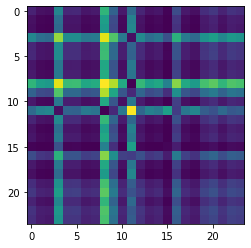

In [ ]:
plt.imshow(im_train[1])
plt.show()

In [ ]:
im_train = np.repeat(im_train[..., np.newaxis], 3, -1)
im_train.shape

(122368, 24, 24, 3)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(im_train, onehot_encoded, train_size=0.7, random_state=7)

In [ ]:
import tensorflow as tf 
from tensorflow import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling3D, Activation, TimeDistributed,Flatten,LSTM,ConvLSTM2D, MaxPooling2D
from keras.models import Model

In [ ]:
model = keras.Sequential()
model.add(Conv2D(128, (2,2), padding = 'same', input_shape=(24, 24, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.5))

model.add(Conv2D(64, (2,2), padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.5))

model.add(Conv2D(32, (2,2), padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.5))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(4))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 16)        208       
                                                                 
 activation_3 (Activation)   (None, 26, 26, 16)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 13, 13, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 16)        1040      
                                                                 
 activation_4 (Activation)   (None, 13, 13, 16)        0         
                                                      

In [ ]:
epochs = 300
batch_size = 64

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,validation_split=0.3)

Epoch 1/300
937/937 [==============================] - 23s 9ms/step - loss: 0.9569 - accuracy: 0.5252 - val_loss: 0.5689 - val_accuracy: 0.7930
Epoch 2/300
937/937 [==============================] - 8s 8ms/step - loss: 0.5392 - accuracy: 0.7918 - val_loss: 0.2660 - val_accuracy: 0.9149
Epoch 3/300
937/937 [==============================] - 8s 9ms/step - loss: 0.3874 - accuracy: 0.8549 - val_loss: 0.1899 - val_accuracy: 0.9414
Epoch 4/300
937/937 [==============================] - 8s 8ms/step - loss: 0.3201 - accuracy: 0.8814 - val_loss: 0.1520 - val_accuracy: 0.9516
Epoch 5/300
937/937 [==============================] - 8s 8ms/step - loss: 0.2847 - accuracy: 0.8953 - val_loss: 0.1242 - val_accuracy: 0.9649
Epoch 6/300
937/937 [==============================] - 8s 8ms/step - loss: 0.2636 - accuracy: 0.9033 - val_loss: 0.1057 - val_accuracy: 0.9701
Epoch 7/300
937/937 [==============================] - 8s 8ms/step - loss: 0.2457 - accuracy: 0.9099 - val_loss: 0.1094 - val_accuracy: 0.969

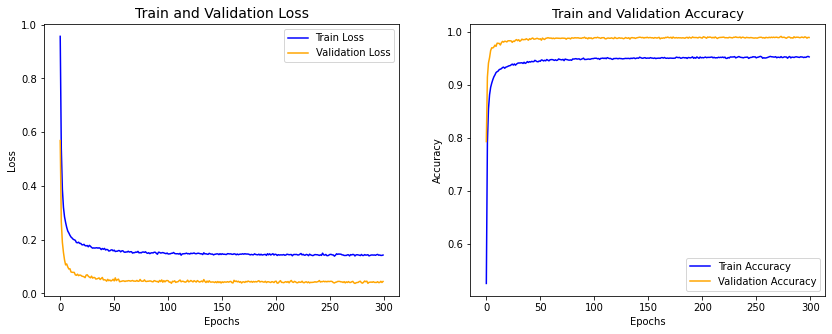

In [ ]:
epochs = [i for i in range(300)]
loss_train = history.history['loss']
acc_train = history.history['accuracy']
loss_test = history.history['val_loss']
acc_test = history.history['val_accuracy']


fig, ax = plt.subplots(1,2, figsize=(14,5))

ax[0].plot(epochs, loss_train, color='blue', label='Train Loss')
ax[0].plot(epochs, loss_test, color='orange', label='Validation Loss')
ax[0].set_title('Train and Validation Loss', fontsize=14)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()



ax[1].plot(epochs, acc_train, color='blue', label='Train Accuracy')
ax[1].plot(epochs, acc_test, color='orange',  label='Validation Accuracy')
ax[1].set_title('Train and Validation Accuracy', fontsize=13)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()

In [ ]:
import time 
s1 = time.time()
y_pred = model.predict(X_test)
s2 = time.time()
s = s2 -s1 
print(s)

3.378390312194824


In [ ]:
import numpy as np
y_predict_non_category = [ np.argmax(t) for t in y_pred ]
y_test_non_category = [np.argmax(t) for t in y_test]

In [ ]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test_non_category, y_predict_non_category)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test_non_category, y_predict_non_category)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test_non_category, y_predict_non_category, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test_non_category, y_predict_non_category, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test_non_category, y_predict_non_category, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test_non_category, y_predict_non_category, average='macro')))

print('Macro Recall: {:.2f}'.format(recall_score(y_test_non_category, y_predict_non_category, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test_non_category, y_predict_non_category, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test_non_category, y_predict_non_category, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_non_category,y_predict_non_category, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_non_category, y_predict_non_category, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test_non_category, y_predict_non_category, target_names=['Class 1', 'Class 2', 'Class 3']))

Confusion Matrix

[[ 9543    57   118]
 [   34 11640    89]
 [   35   106 15089]]

Accuracy: 0.99

Micro Precision: 0.99
Micro Recall: 0.99
Micro F1-score: 0.99

Macro Precision: 0.99
Macro Recall: 0.99
Macro F1-score: 0.99

Weighted Precision: 0.99
Weighted Recall: 0.99
Weighted F1-score: 0.99

Classification Report

              precision    recall  f1-score   support

     Class 1       0.99      0.98      0.99      9718
     Class 2       0.99      0.99      0.99     11763
     Class 3       0.99      0.99      0.99     15230

    accuracy                           0.99     36711
   macro avg       0.99      0.99      0.99     36711
weighted avg       0.99      0.99      0.99     36711



Text(0.5, 257.44, 'Predicted label')

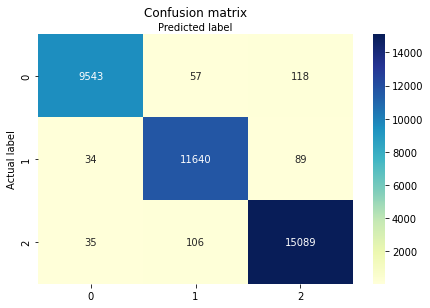

In [ ]:
import seaborn as sns
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test_non_category, y_predict_non_category)
cnf_matrix
%matplotlib inline
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

(1, 24, 24, 128)
(1, 12, 12, 128)
(1, 12, 12, 128)
(1, 12, 12, 64)
(1, 12, 12, 64)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


(1, 6, 6, 64)
(1, 6, 6, 64)
(1, 6, 6, 32)
(1, 6, 6, 32)
(1, 3, 3, 32)
(1, 3, 3, 32)
(1, 3, 96)
(1, 4)
(1, 3)


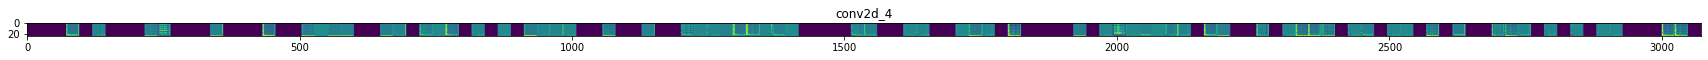

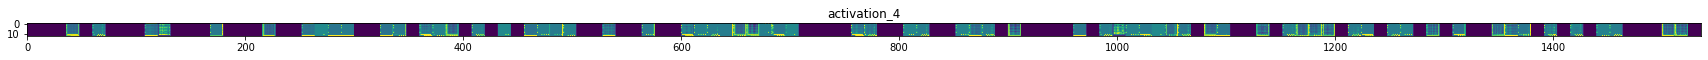

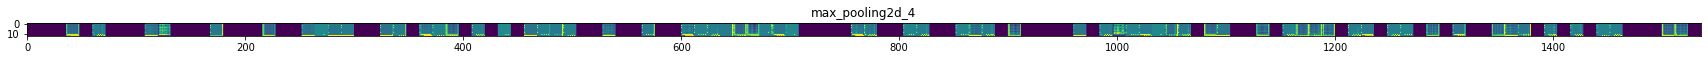

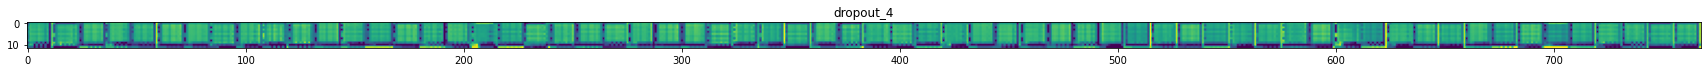

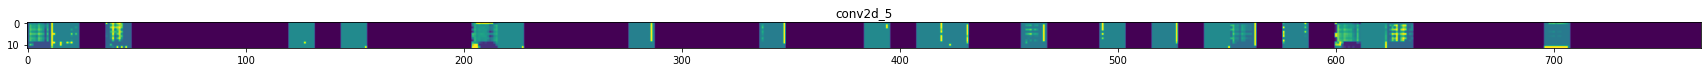

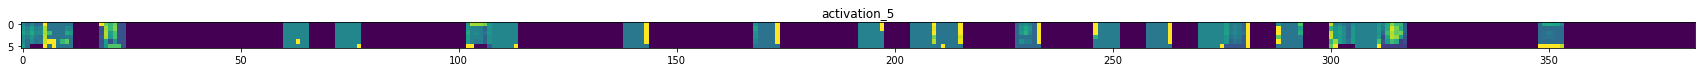

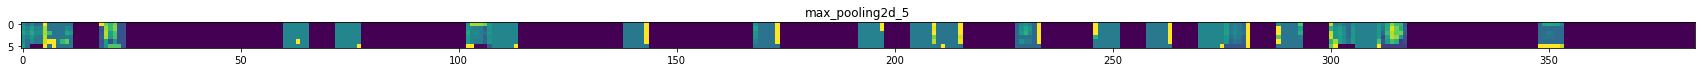

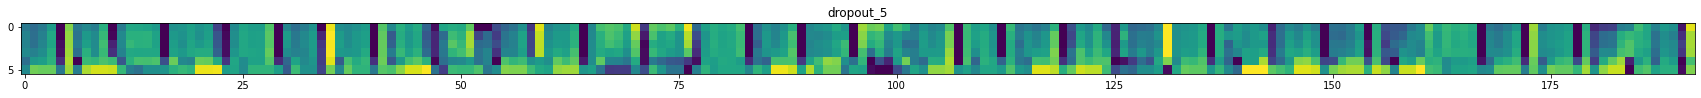

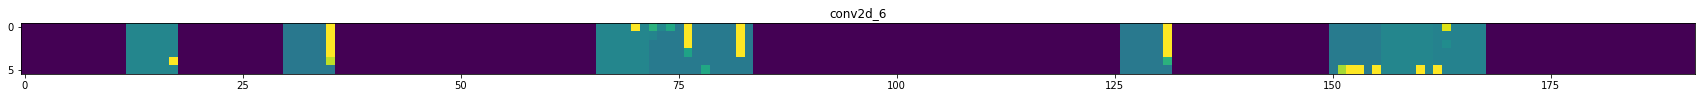

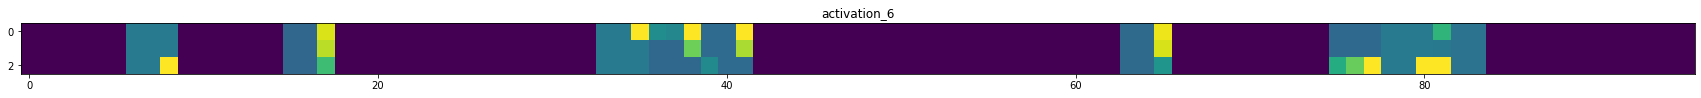

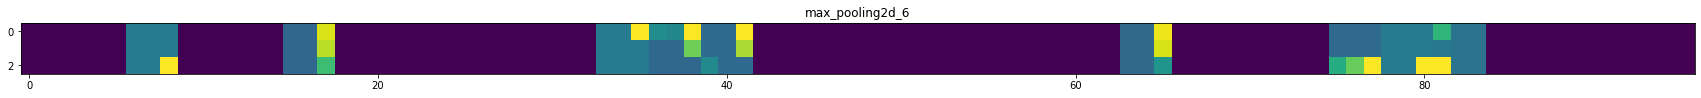

In [ ]:
img_path='/content/drive/MyDrive/Brain Computer Interface/download.png' #dog
# Define a new Model, Input= image 
# Output= intermediate representations for all layers in the  
# previous model after the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
#Load the input image
img = load_img(img_path, target_size=(24,24))
# Convert ht image to Array of dimension (150,150,3)
x   = img_to_array(img)                           
x   = x.reshape((1,) + x.shape)
# Rescale by 1/255
x /= 255.0
# Let's run input image through our vislauization network
# to obtain all intermediate representations for the image.
successive_feature_maps = visualization_model.predict(x)
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
   
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
# Display the grid
    scale = 30. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

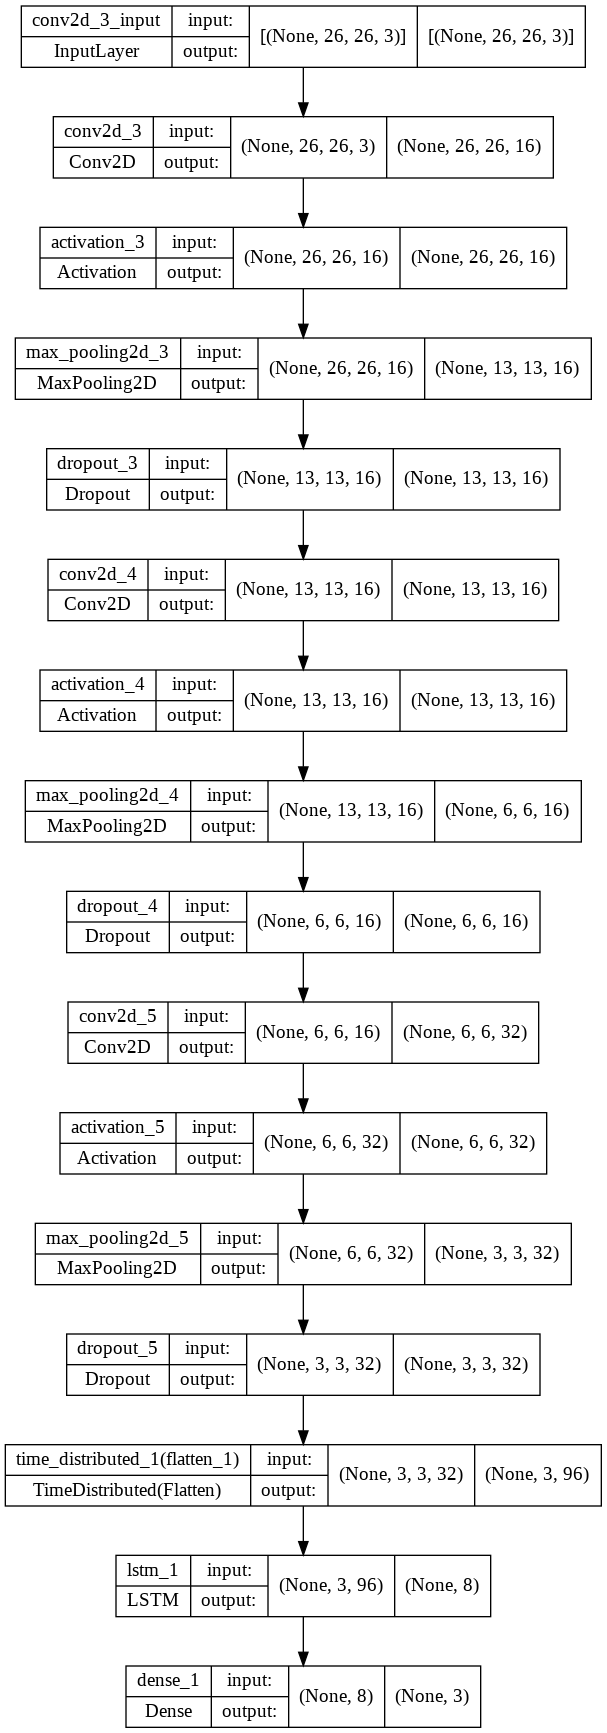

In [ ]:
import tensorflow as tf
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [ ]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

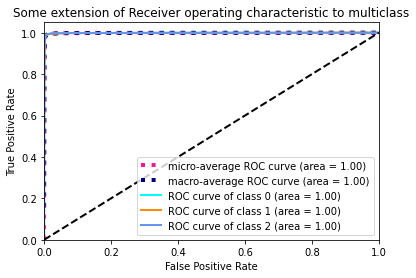

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(3):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 3

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(3), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()